In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

2024-10-23 19:39:53.953149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 19:39:53.962281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 19:39:53.965086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 19:39:53.974575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 19:39:54.599286: W tensorflow/compiler/tf2

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
else:
    print("No GPU available.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1729705195.292202    8774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729705195.313893    8774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729705195.313948    8774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


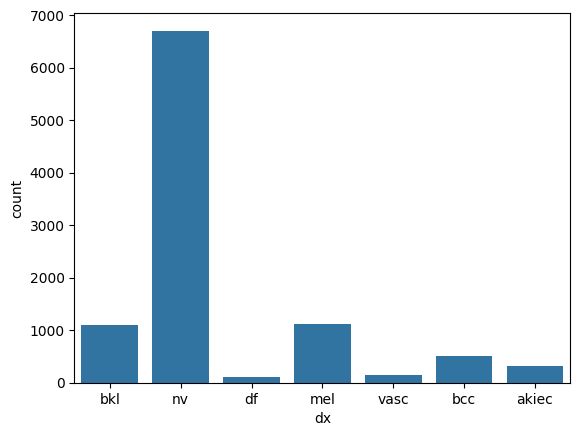

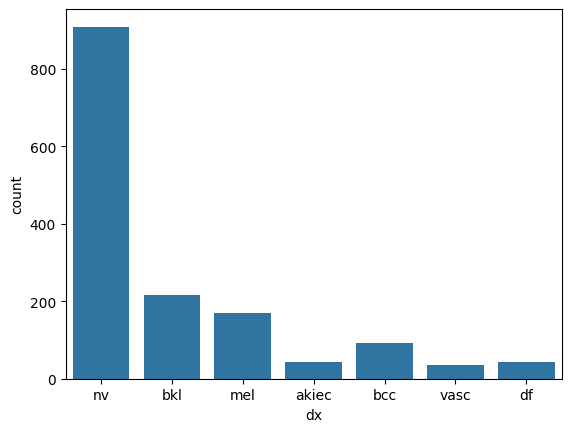

In [3]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  
test_image_dir = 'data/ham10000/images/test_images/'

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.show()

test_data_path = 'data/ham10000/images/ISIC2018_Task3_Test_GroundTruth.csv'

test_df = pd.read_csv(test_data_path)
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'
test_df['label'] = label_encoder.transform(test_df['dx'])

sns.countplot(x='dx', data=test_df)
plt.show()

train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

In [4]:
print(train_df['label'].unique())  
print(val_df['label'].unique())    
print(test_df['label'].unique())   

[1 5 2 0 6 4 3]
[5 4 2 0 1 3 6]
[5 2 4 0 1 6 3]


In [5]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [6]:
image_size = (128, 128)  
batch_size = 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9013 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.


/home/bosa/manu2/manu/.venv/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [7]:
class CustomCNN(models.Model):
    def __init__(self, layers_list):
        super(CustomCNN, self).__init__()
        self.model = models.Sequential()
        for layer in layers_list:
            self.model.add(layer)
    
    def call(self, inputs):
        return self.model(inputs)

In [8]:
def create_baseline_model(input_shape=(128, 128, 3), num_classes=7):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

baseline_model = create_baseline_model()

baseline_model.summary()

if train_generator is None:
    raise ValueError("train_generator is not initialized.")
if val_generator is None:
    raise ValueError("val_generator is not initialized.")

history = baseline_model.fit(train_generator, validation_data=val_generator, epochs=20)

I0000 00:00:1729705197.529357    8774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729705197.529423    8774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729705197.529456    8774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729705197.696541    8774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729705197.696602    8774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,183 (12.61 MB)

 Trainable params: 3,305,863 (12.61 MB)

 Non-trainable params: 320 (1.25 KB)

/home/bosa/manu2/manu/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1729705201.220710    8854 service.cc:146] XLA service 0x7fe01c004c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729705201.220735    8854 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-10-23 19:40:01.251457: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 19:40:01.441646: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 2/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2246 - auc: 0.5230 - loss: 4.4952 

I0000 00:00:1729705208.169277    8854 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 57s 693ms/step - accuracy: 0.5844 - auc: 0.8501 - loss: 2.3531 - val_accuracy: 0.6697 - val_auc: 0.7956 - val_loss: 2.7229
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 614ms/step - accuracy: 0.6898 - auc: 0.9368 - loss: 0.8878 - val_accuracy: 0.6617 - val_auc: 0.8083 - val_loss: 3.1219
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 611ms/step - accuracy: 0.7074 - auc: 0.9464 - loss: 0.8019 - val_accuracy: 0.6427 - val_auc: 0.8428 - val_loss: 2.6645
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 602ms/step - accuracy: 0.7296 - auc: 0.9540 - loss: 0.7372 - val_accuracy: 0.6537 - val_auc: 0.8155 - val_loss: 3.9745
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 609ms/step - accuracy: 0.7455 - auc: 0.9604 - loss: 0.6854 - val_accuracy: 0.6088 - val_auc: 0.8337 - val_loss: 2.3321
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 615ms/step - accuracy: 0.7363 - auc: 0.9572 - loss: 0.7094 - val_accuracy: 0.5888 - val_auc: 0.8255 - val_loss: 3.2657
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 613

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 631ms/step - accuracy: 0.6608 - auc: 0.9261 - loss: 0.9961
Test Accuracy: 0.6512243747711182
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step
ROC AUC Score: 0.4932633718692145
F1 Score: 0.43782200384386


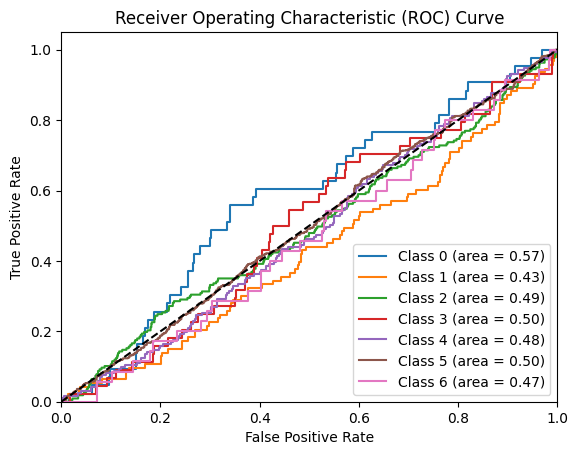

In [9]:
test_results = baseline_model.evaluate(test_generator, steps=len(test_generator))
test_loss, test_acc = test_results[0], test_results[1]
print(f'Test Accuracy: {test_acc}')

y_true = test_generator.classes
y_pred_prob = baseline_model.predict(test_generator)
y_pred = y_pred_prob.argmax(axis=1)

roc_auc = roc_auc_score(to_categorical(y_true), y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

num_classes = len(train_generator.class_indices)  
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [12]:
def create_custom_cnn(hp):
    input_shape = (128, 128, 3)
    conv_filters = hp.Int('conv_filters', min_value=32, max_value=256, step=32)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    activation = hp.Choice('activation', values=['relu', 'elu'])

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(conv_filters, (3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(2 * conv_filters, (3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(4 * conv_filters, (3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

In [ ]:
from keras_tuner import BayesianOptimization

tuner = BayesianOptimization(
    create_custom_cnn,
    objective='accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='ham10000_tuning'
)

# Run the tuning process
tuner.search(train_generator, 
             epochs=5,
             validation_data=val_generator)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
test_results = best_model.evaluate(test_generator, steps=len(test_generator))
test_loss, test_acc = test_results[0], test_results[1]
print(f'Test Accuracy of Best Model: {test_acc}')

# Get and print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

Reloading Tuner from my_dir/ham10000_tuning/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
96                |160               |conv_filters
0.0017386         |0.0027084         |learning_rate
0.2               |0.3               |dropout_rate
elu               |elu               |activation

Epoch 1/5
42/71 ━━━━━━━━━━━━━━━━━━━━ 21s 729ms/step - accuracy: 0.4226 - auc: 0.7343 - loss: 23.3871

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

test_results = best_model.evaluate(test_generator, steps=len(test_generator))
test_loss, test_acc = test_results[0], test_results[1]
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

y_true = test_generator.classes  
y_pred_prob = best_model.predict(test_generator)  
y_pred = y_pred_prob.argmax(axis=1)  

roc_auc = roc_auc_score(to_categorical(y_true), y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

num_classes = len(train_generator.class_indices) 
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()